# **Part 1 - Methods for Asian Options** #

### University of Warwick

##### MA9070: Simulation and Machine Learning

*By Seb Murphy (u5586152)*


---
---

## *Introduction*

In the realm of financial derivatives, Asian options present a unique characteristic where the payoff is determined by the average underlying asset price over a preset time interval, as to opposed to just the price at maturity like European options. In this project, we focus on a specific type of Asian option known as a Fixed Strike Asian Call Option with Discrete Arithmetic Average. The underlying asset follows a local volatility model, that is a geometric Brownian motion model that allows for the volatility to depend both on the time and the current value of the asset. The payoff for this option is given by: 

$$
\max(\frac{1}{Nsteps} \sum_n S_n - K, 0)
$$

The objective for this part of the project is to employ Monte Carlo simulations for pricing Asian options, considering different variance reduction techniques, namely the antithetic and control variate models. The methods will then be evaluated and compared to determined which method is most efficient. To assess how the option price varies against a range of spot prices, the antithetic variance reduction method will be used. Finally, the delta for the Asian option will be calculated and plotted as function of spot price, including an critical discussion of the delta option from a financial perspective. 




---

## *Pricing Asian Options*

In this section we will consider different methods to price Asian options. Functions will created to calculate the local volatility at a given time and asset value using the specified local volatility model, to employ the Euler method to simulate paths of the underlying asset's price via geometric Brownian motion, and to compute the payoff of the specific Asian option utilised in this report. 

Firstly, the Monte Carlo technique without variance reduction will be employed. This works by directly calculating the average payoff with no variance reduction techniques. 

Next, we will consider the antithetic variance reduction model which involves generating pairs of positively and negatively correlated paths to reduce the overall variance. This is achieved by averaging the payoffs from both paths.

Finally, the price of an Asian option will be conducted through the control variates technique. This method works by introducing a correlated auxiliary variable to reduce variance, in this case 2 will be considered:  
- Control Variate 1 = ZT
- Control Variate 2 = $exp(-rT)*max(ZT - K,0)$


In [1]:
# Importing the required libraries and functions for computation
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from  BlackScholes import BS_price

In [2]:
# Construct random generator 
rng = np.random.default_rng(12345)

In [3]:
# Function to compute and return the local volatility
def volatility(S,t,sigma_0):  
    sigma_1 = 0.3
    sigma_2 = 0.5
    sigma = sigma_0 * (1 + sigma_1 * np.cos(2 * np.pi * t)) * (1 + sigma_2 * np.exp(-S/50))
    
    return sigma

In [4]:
# Function for Euler time-stepping of the stochastic differential equation
def SDE_timestepper(S0, K, T, r, sigma_0, Npaths): 
    # Number of time steps (daily) for the Euler time-stepping
    Nsteps = int(260 * T)
    
    # Time array and time step
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    
    # Arrays to store positive and negative paths for the Asian option
    Sp = np.zeros((Nsteps + 1, Npaths))
    Sm = np.zeros((Nsteps + 1, Npaths))
    
    # Initialize paths with the initial spot price
    Sp[0,:] = S0  
    Sm[0,:] = S0 
    
    # Generate paths using Euler time-stepping
    for n in range(Nsteps):
        # Calculate local volatility for positive and negative paths
        sigma1 = volatility(Sp[n,:],t[n],sigma_0)
        sigma2 = volatility(Sm[n,:],t[n],sigma_0)
        
        # Generate random increments using the normal distribution
        dW = np.sqrt(dt) * rng.normal(0, 1, Npaths)
        
        # Update positive and negative paths using the Euler scheme
        Sp[n+1,:] = Sp[n,:] * (1 + r*dt + sigma1 * dW[:])
        Sm[n+1,:] = Sm[n,:] * (1 + r*dt - sigma2 * dW[:])
        
    return t, Sp, Sm

In [5]:
# Price an Asian option by basic Monte Carlo method
def MC_asian_option(S, K, T, r, sigma_0, Npaths):
    # Set initial spot price
    S0 = S
    
    # Use time_stepper to only get relevant daily closing prices S (postive path) 
    t, S, _ = SDE_timestepper(S0, K, T, r, sigma_0, Npaths)
    
    # Find price and variance of Asian option
    fS = np.exp(-r*T)*np.maximum(np.mean(S,axis=0) - K, 0)
    price = np.mean(fS)
    variance = np.var(fS)
    
    return price, variance



In [6]:
# Price an Asian option using Antithetic variance reduction techniques
def MC_asian_option_ant(S, K, T, r, sigma_0, Npaths):
    # Set initial spot price
    S0 = S
    
    # Use the SDE_timestepper function to generate positive and negative paths
    t, Sp, Sm = SDE_timestepper(S0, K, T, r, sigma_0, Npaths)

    # Discounted payoffs for positive and negative paths
    fSp = np.exp(-r*T)*np.maximum(np.mean(Sp,axis=0) - K, 0)
    fSm = np.exp(-r*T)*np.maximum(np.mean(Sm,axis=0) - K, 0)
    
    # Calculate the antithetic variable Z as the average of discounted payoffs
    Z = (fSp + fSm)/2
    
    # Compute the mean and variance of the Asian option price
    price = np.mean(Z)
    variance = np.var(Z)
    
    return price, variance


In [7]:
# Function to simulat path of control variate Zt with constant variance
def simulate_Z_path(S0, K, T, r, sigma, Npaths):
    Nsteps = int(260 * T)
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    Z = np.zeros((Nsteps + 1, Npaths))

    # Time step starting from initial condition, where S are daily closing proces of the underlying GBM process
    Z[0,:] = S0  
    
    # Compute constant variance
    sigma_bar = volatility(S0, T, sigma)
    
    # Simulate Z GBM paths
    for n in range(Nsteps):
        dW = np.sqrt(dt) * rng.normal(0, 1, Npaths)
        Z[n+1,:] = Z[n,:] * (1 + r*dt + sigma_bar * dW[:])
        
    return Z

In [8]:
# Price an Asian option using Control Variate ZTs
def MC_asian_option_con1(S, K, T, r, sigma, Npaths):
    
    # Set parameters
    S0 = S
    
    # The mean for the first control variate ZT is known - just mean of geometric brownian motion
    mean = S0 * np.exp(r*T)

    #Set up control variate ZT
    Zt = simulate_Z_path(S0, K, T, r, sigma, Npaths)
    ZT = Zt[-1, :]
    
    # Find discounted price of Asian option
    t, S, _ = SDE_timestepper(S0, K, T, r, sigma, Npaths)
    fS = np.exp(-r*T)*np.maximum(np.mean(S,axis=0) - K, 0)
    
    #Find covarince
    cov_fS_ZT = np.mean(fS * ZT) - np.mean(fS) * np.mean(ZT)
    
    # Find optimal c by euqation from lectures
    c = cov_fS_ZT/np.var(ZT)
    
    # Find Control variate and compute the price and variance
    fc = fS - c * (ZT - mean)
    price = np.mean(fc)
    var = np.var(fc)
    
    return price, var

In [9]:
# Price an Asian option using Control Variate of discounted European option
def MC_asian_option_con2(S, K, T, r, sigma, Npaths):
    
    # Set parameters
    S0 = S
    
    # The mean for the second control variate is known - just mean from Black Scholes formula
    mean_BS, _ = BS_price(S0, K, T, r, sigma)

    #Set up control variate
    Zt = simulate_Z_path(S0, K, T, r, sigma_0, Npaths)
    ZT = Zt[-1, :]
    g = np.exp(-r*T)*np.maximum(ZT - K, 0)
    
    # Find discounted price of Asian option
    t, S, _ = SDE_timestepper(S0, K, T, r, sigma, Npaths)
    fS = np.exp(-r*T)*np.maximum(np.mean(S,axis=0) - K, 0)
    
    #Find covarince
    cov_fS_ZT = np.mean(fS * g) - np.mean(fS) * np.mean(g)
    
    # Find optimal c by euqation from lectures
    c = cov_fS_ZT/np.var(g)
    
    # Find Control variate and compute the price and variance
    fc = fS - c * (g - mean_BS)
    price = np.mean(fc)
    var = np.var(fc)
    
    return price, var

The results from each method is shown below for Spot Price = 120, including the 95% confidence interval for the option price computed. The European Call Option price is also shown for validation of the models.

In [10]:
# Set initial parameters
S = 120
K = 110
T = 3
r = 0.05
sigma_0 = 0.2
Npaths = 1000

# Price an Asian option by basic Monte Carlo method
Asian_price, Asian_var = MC_asian_option(S, K, T, r, sigma_0, Npaths)
SEM = np.sqrt(Asian_var/Npaths)
print("Asian Price by Naive Monte Carlo = ", '{0:.5g}'.format(Asian_price), "+/-", '{0:.2g}'.format(1.96*SEM))
print("Variance by Naive Monte Carlo = ", '{0:.5g}'.format(Asian_var))

# Price an Asian option using Antithetic variance reduction techniques
Asian_price, Asian_var = MC_asian_option_ant(S, K, T, r, sigma_0, Npaths)
SEM = np.sqrt(Asian_var/Npaths)
print("\nAsian Price using Antithetic variance reduction = ", '{0:.5g}'.format(Asian_price), "+/-", '{0:.2g}'.format(1.96*SEM))
print("Variance using Antithetic variance reduction = ", '{0:.5g}'.format(Asian_var))

# Price an Asian option using Control Variate 1 reduction techniques
Asian_price, Asian_var = MC_asian_option_con1(S, K, T, r, sigma_0, Npaths)
SEM = np.sqrt(Asian_var/Npaths)
print("\nAsian Price using Control Variate 1 variance reduction = ", '{0:.5g}'.format(Asian_price), "+/-", '{0:.2g}'.format(1.96*SEM))
print("Variance using Control Variate 1 variance reductiono = ", '{0:.5g}'.format(Asian_var))

# Price an Asian option using Control Variate 2 reduction techniques
Asian_price, Asian_var = MC_asian_option_con2(S, K, T, r, sigma_0, Npaths)
SEM = np.sqrt(Asian_var/Npaths)
print("\nAsian Price using Control Variate 2 variance reduction = ", '{0:.5g}'.format(Asian_price), "+/-", '{0:.2g}'.format(1.96*SEM))
print("Variance using Control Variate 2 variance reductiono = ", '{0:.5g}'.format(Asian_var))

# Test for validation of Black Scholes Call option price
BS_call_price, _ = BS_price(S, K, T, r, sigma_0)
print("\nBlack-Scholes European Call option price = ", '{0:.5g}'.format(BS_call_price))


Asian Price by Naive Monte Carlo =  21.287 +/- 1.3
Variance by Naive Monte Carlo =  459.2

Asian Price using Antithetic variance reduction =  19.142 +/- 0.47
Variance using Antithetic variance reduction =  58.453

Asian Price using Control Variate 1 variance reduction =  18.755 +/- 1.3
Variance using Control Variate 1 variance reductiono =  457.2

Asian Price using Control Variate 2 variance reduction =  18.634 +/- 1.3
Variance using Control Variate 2 variance reductiono =  420.44

Black-Scholes European Call option price =  30.695


Therefore, it is shown that the antithetic variance reduction has the minimal variance, hence is the most effective method at reducing the variance for pricing asian options. The above results clearly show that the control variates 1 and 2 have very little effect in reducing the variance. This could be due to several reasons. Firstly, the payoff structure of the Asian option is path-dependent, involving the average of underlying asset prices over Nsteps rather than a single terminal value. This path dependency introduces nonlinearity in the payoff function, making it challenging to find control variates with a linear relationship to the option's value. Secondly, the control variates provided are linear transformations of ZT, and the effectiveness of control variates relies on strong correlations, which may not be present in this case. Additionally, the complexity of the option's payoff formula, coupled with the nontrivial nature of finding suitable control variates for path-dependent options, could limit the practical utility of the chosen control variates in reducing variance. Moreover, the explicit form of the control variates involves the terminal value ZT, and its correlation with the average payoff of the Asian option might not be sufficient for achieving meaningful variance reduction, as can be seen above. 

Further, it can also be seen that the asian option are lower in value then the European Call option, calculated using the Black Scholes Formula. This is due to their averaging feature. The payoff of an Asian option is based on the average price of the underlying asset over a specific period rather than just the spot price at maturity, as is the case with European options. The averaging mechanism reduces the impact of short-term price fluctuations, making the option less sensitive to market volatility. Consequently, the reduced sensitivity to individual price movements translates to a lower premium for Asian options compared to their European counterparts. 


---

# Comparing Methods for Asian Option Pricing 

The different methods from above will be compared in this section. To achieve this, the option price for each method will be computed at three different spot prices (S0 < K, S0 = k, S0 > K), and the 95% confidence interval in each case will be obtained and plotted.


In [11]:
# Computing the option price for each method for different spot prices

# Spot price for evaluation and initial parameters
spot_prices = [70, 110, 180]
K = 110
T = 3
r = 0.05
sigma_0 = 0.2
Npaths = 1000

# Storage of option prices and variances
naive_prices = np.zeros((len(spot_prices), 2))
ant_prices = np.zeros((len(spot_prices), 2))
con1_prices = np.zeros((len(spot_prices), 2))
con2_prices = np.zeros((len(spot_prices), 2))

# Evaluate option prices for each spot price using different methods
for i in range(len(spot_prices)):
    # Naive method
    naive_prices[i, 0], naive_prices[i, 1] = MC_asian_option(spot_prices[i], K, T, r, sigma_0, Npaths)  
    
    # Antithetic variance reduction method
    ant_prices[i, 0], ant_prices[i, 1] = MC_asian_option_ant(spot_prices[i], K, T, r, sigma_0, Npaths) 
    
    # Control Variates reduction method
    con1_prices[i, 0], con1_prices[i, 1] = MC_asian_option_con1(spot_prices[i], K, T, r, sigma_0, Npaths) 
    con2_prices[i, 0], con2_prices[i, 1] = MC_asian_option_con2(spot_prices[i], K, T, r, sigma_0, Npaths) 

The option prices for each method at the spot prices: 90, 110, 130; are shown below, including their 95% Confidence Interval. 

In [12]:
# Obtain 95% Confidence Intervals for each method

# Storage for standard error of the means (SEM) for each methods option prices
SEM_naive = np.zeros(len(spot_prices))
SEM_ant = np.zeros(len(spot_prices))
SEM_con1 = np.zeros(len(spot_prices))
SEM_con2 = np.zeros(len(spot_prices))

# Compute SEM for each method
for j in range(len(spot_prices)):
    SEM_naive[j] = np.sqrt(naive_prices[j,1]/Npaths)
    SEM_ant[j] = np.sqrt(ant_prices[j,1]/Npaths)
    SEM_con1[j] = np.sqrt(con1_prices[j,1]/Npaths)
    SEM_con2[j] = np.sqrt(con2_prices[j,1]/Npaths)
    
# Ouput the 95% Confidence Interval for each method
for k in range(len(spot_prices)):
    print("\nFor Spot price =", spot_prices[k], ":")
    print("--------------------------------")
    print("The Asian Price by Naive Monte Carlo = ", '{0:.5g}'.format(naive_prices[k, 0],4), "with 95% confidence interval: [",
          '{0:.2g}'.format(naive_prices[k, 0] - 1.96*SEM_naive[k]), ',', '{0:.2g}'.format(naive_prices[k, 0] + 1.96*SEM_naive[k]),']')
    print("The Asian Price by Antithetic Variance Reduction = ", '{0:.5g}'.format(ant_prices[k, 0],4), "with 95% confidence interval: [",
          '{0:.2g}'.format(ant_prices[k, 0] - 1.96*SEM_ant[k]), ',', '{0:.2g}'.format(ant_prices[k, 0] + 1.96*SEM_ant[k]),']')
    print("The Asian Price by Control Variate 1 Reduction = ", '{0:.5g}'.format(con1_prices[k, 0],4), "with 95% confidence interval: [",
          '{0:.2g}'.format(con1_prices[k, 0] - 1.96*SEM_con1[k]), ',', '{0:.2g}'.format(con1_prices[k, 0] + 1.96*SEM_con1[k]),']')
    print("The Asian Price by Control Variate 2 Reduction = ", '{0:.5g}'.format(con2_prices[k, 0],4), "with 95% confidence interval: [",
          '{0:.2g}'.format(con2_prices[k, 0] - 1.96*SEM_con2[k]), ',', '{0:.2g}'.format(con2_prices[k, 0] + 1.96*SEM_con2[k]),']')


For Spot price = 70 :
--------------------------------
The Asian Price by Naive Monte Carlo =  0.32525 with 95% confidence interval: [ 0.16 , 0.49 ]
The Asian Price by Antithetic Variance Reduction =  0.39542 with 95% confidence interval: [ 0.29 , 0.5 ]
The Asian Price by Control Variate 1 Reduction =  0.26882 with 95% confidence interval: [ 0.16 , 0.38 ]
The Asian Price by Control Variate 2 Reduction =  0.2855 with 95% confidence interval: [ 0.16 , 0.41 ]

For Spot price = 110 :
--------------------------------
The Asian Price by Naive Monte Carlo =  12.343 with 95% confidence interval: [ 11 , 13 ]
The Asian Price by Antithetic Variance Reduction =  12.752 with 95% confidence interval: [ 12 , 13 ]
The Asian Price by Control Variate 1 Reduction =  12.818 with 95% confidence interval: [ 12 , 14 ]
The Asian Price by Control Variate 2 Reduction =  11.826 with 95% confidence interval: [ 11 , 13 ]

For Spot price = 180 :
--------------------------------
The Asian Price by Naive Monte Carlo


The plots below show the 95% Confidence intervals with error bars (top) and the 95% Confidence intervals using the fill between method (bottom) for each method. 


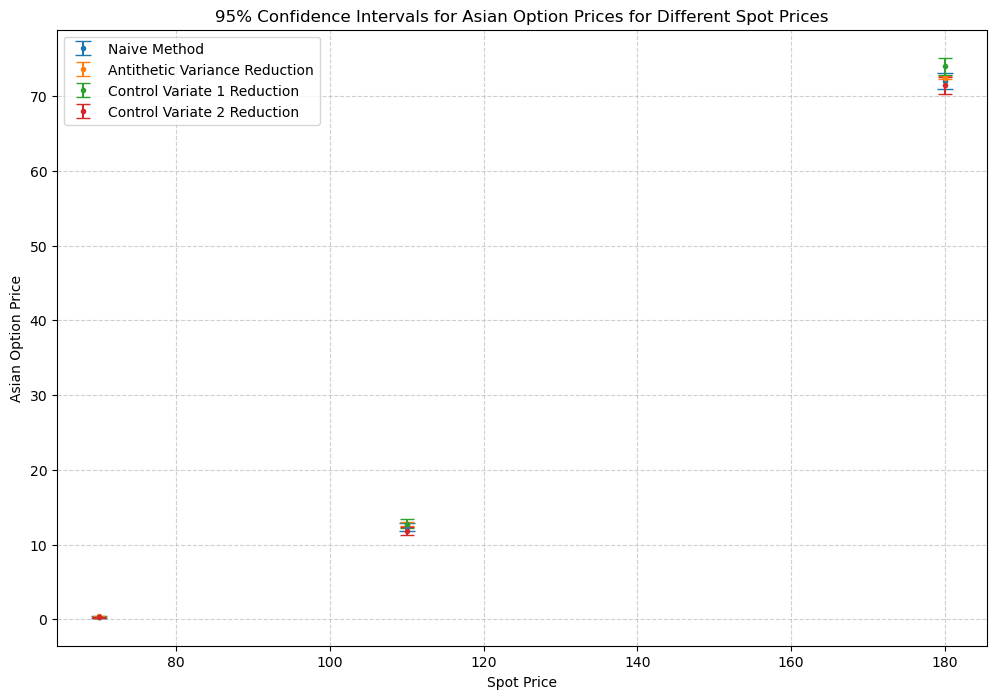

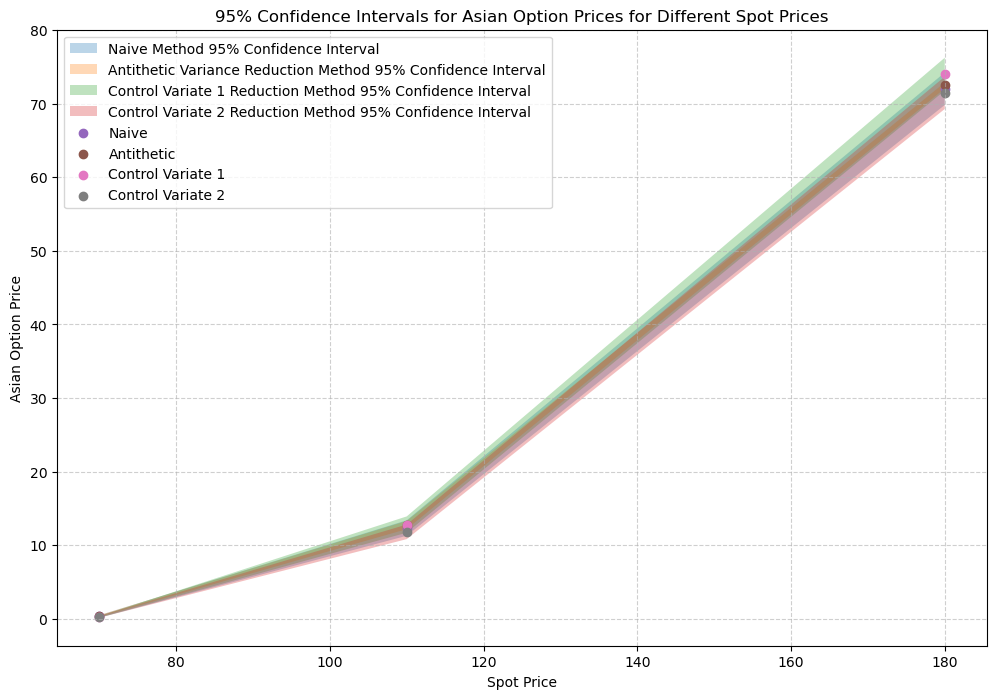

In [13]:
# Plotting the 95% Confidence intervals to aid visulisation for each method

# Plotting 95% Confidence intervals with error bars
plt.figure(figsize=(12, 8))
plt.errorbar(spot_prices, naive_prices[:, 0], yerr=SEM_naive, fmt = 'o', label='Naive Method', capsize=6, markersize = 3)
plt.errorbar(spot_prices, ant_prices[:,0], yerr=SEM_ant, fmt = 'o', label='Antithetic Variance Reduction', capsize=5, markersize = 3)
plt.errorbar(spot_prices, con1_prices[:,0], yerr=SEM_con1, fmt = 'o', label='Control Variate 1 Reduction', capsize=5, markersize = 3)
plt.errorbar(spot_prices, con2_prices[:,0], yerr=SEM_con2, fmt = 'o', label='Control Variate 2 Reduction', capsize=5, markersize = 3)

plt.xlabel("Spot Price")
plt.ylabel("Asian Option Price")
plt.title("95% Confidence Intervals for Asian Option Prices for Different Spot Prices")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plotting 95% Confidence intervals using fill_between method
plt.figure(figsize=(12, 8))
plt.fill_between(spot_prices, naive_prices[:, 0] - 1.96*SEM_naive, naive_prices[:, 0] + 1.96*SEM_naive, alpha=0.3, label='Naive Method 95% Confidence Interval')
plt.fill_between(spot_prices, ant_prices[:, 0] - 1.96*SEM_ant, ant_prices[:, 0] + 1.96*SEM_ant, alpha=0.3, label='Antithetic Variance Reduction Method 95% Confidence Interval')
plt.fill_between(spot_prices, con1_prices[:, 0] - 1.96*SEM_con1, con1_prices[:, 0] + 1.96*SEM_con1, alpha=0.3, label='Control Variate 1 Reduction Method 95% Confidence Interval')
plt.fill_between(spot_prices, con2_prices[:, 0] - 1.96*SEM_con2, con2_prices[:, 0] + 1.96*SEM_con2, alpha=0.3, label='Control Variate 2 Reduction Method 95% Confidence Interval')
plt.scatter(spot_prices, naive_prices[:, 0], label = 'Naive')
plt.scatter(spot_prices, ant_prices[:, 0], label = 'Antithetic')
plt.scatter(spot_prices, con1_prices[:, 0], label = 'Control Variate 1')
plt.scatter(spot_prices, con2_prices[:, 0], label = 'Control Variate 2')

plt.xlabel("Spot Price")
plt.ylabel("Asian Option Price")
plt.title("95% Confidence Intervals for Asian Option Prices for Different Spot Prices")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The plots below highlights the 95% Confidence intervals for the antithetic variance method, since this gives the minimal variance. 

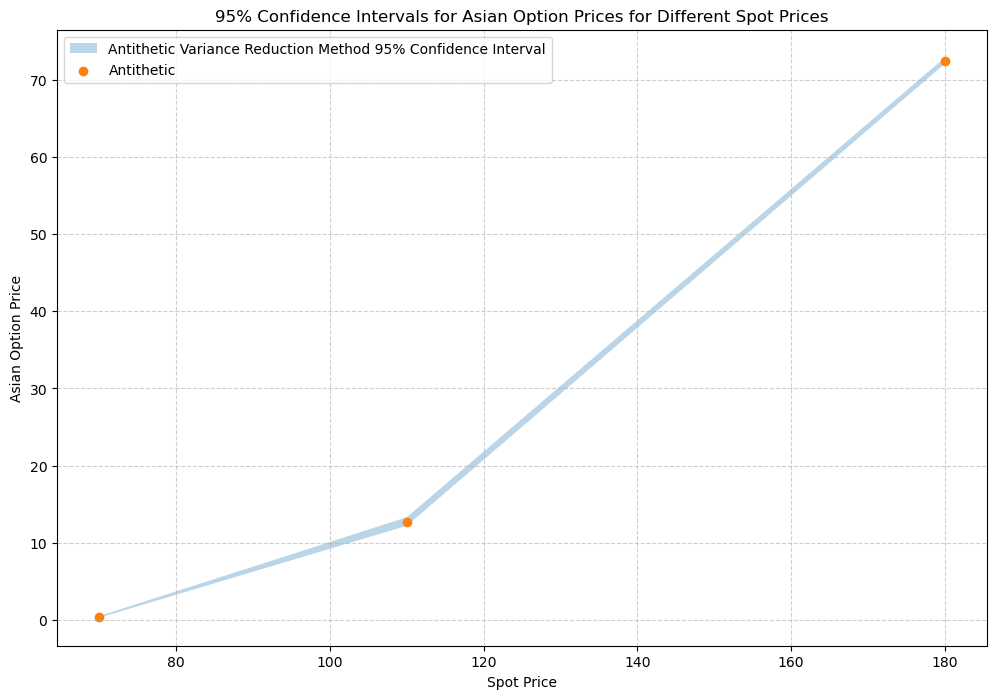

In [14]:
# Plotting 95% Confidence intervals using fill_between method
plt.figure(figsize=(12, 8))
plt.fill_between(spot_prices, ant_prices[:, 0] - 1.96*SEM_ant, ant_prices[:, 0] + 1.96*SEM_ant, alpha=0.3, label='Antithetic Variance Reduction Method 95% Confidence Interval')
plt.scatter(spot_prices, ant_prices[:, 0], label = 'Antithetic')

plt.xlabel("Spot Price")
plt.ylabel("Asian Option Price")
plt.title("95% Confidence Intervals for Asian Option Prices for Different Spot Prices")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The naive Monte Carlo method serves as a straightforward baseline for Asian option pricing. However, it exhibits higher variance, leading to less accurate estimates and potential computational inefficiency for complex payoff structures. The antithetic variance reduction method reduces overall variance, providing more accurate estimates and narrower confidence intervals. Despite these benefits, introducing antithetic variables adds complexity to the simulation code. The control variates method, while also reducing variance, requires domain knowledge to identify suitable variates, introducing additional complexity.

Prima facie, both variance reduction techniques seem efficient, but they come with additional computational costs. The antithetic variance method incurs costs in generating antithetic paths, while the control variates method involves integrating information from a related security into the simulation process.

Considering the trade-offs, antithetic variance reduction and control variates are beneficial in high-variance situations, but their effectiveness depends on problem complexity and the chosen variate's quality. Striking a balance between accuracy and computational efficiency is crucial, taking into account factors like resource availability and problem complexity.

In conclusion, the decision to use variance reduction techniques depends on evaluating the trade-offs between computational cost and desired variance reduction. For scenarios where reducing variance is critical, antithetic variance reduction or control variates may be justified. However, in simpler scenarios or resource-constrained environments, a more straightforward approach like naive Monte Carlo might be preferred. The optimal choice hinges on the specific characteristics of the option, accuracy requirements, and available computational resources. Thorough testing and validation across various scenarios are essential in making an informed decision.


---

## *Evaluating the Asian option price with different stock prices*

The Asian option price will be plotted as a function of spot price over the range S0 = 10 to S0 = 180. The method employed to price the options will be the antithetic variance reduction technique since this gives the minimal variance. Then the Asian option will be contrasted with the European counterparts. To end this section, we evaluate how the time to maturity affects the Asian option prices for over various spot prices. 

The plot below shows the Asian option prices for different spot prices, including its 95% confidence interval represented by the light blue shaded region. 

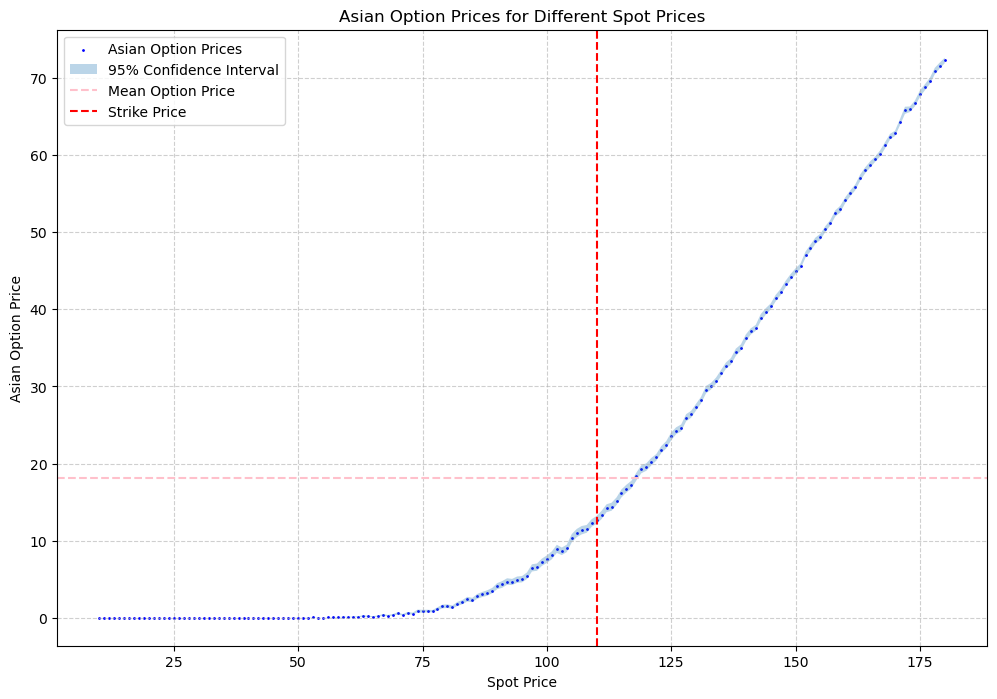

In [15]:
# Plot Asian option prices over different spot prices

# Set initial parameters inclduing the range of spot prices to be evaluated
spot_prices = np.arange(10, 181)
K = 110
T = 3
r = 0.05
sigma_0 = 0.2
Npaths = 1000

# Set storage for option prices and variances over various spot prices
asian_price_list = np.zeros(len(spot_prices))
asian_var = np.zeros(len(spot_prices))

# Compute asian option prices for each spot price
for i in range(len(spot_prices)):
    asian_price_list[i], asian_var[i] = MC_asian_option_ant(spot_prices[i], K, T, r, sigma_0, Npaths)
    
# Plot results with 95% confidence interval, including vertical line for strike price
plt.figure(figsize=(12, 8))  
plt.scatter(spot_prices, asian_price_list, color='blue', label='Asian Option Prices', marker='o', s=1)
plt.fill_between(spot_prices, asian_price_list - 1.96*np.sqrt( asian_var/Npaths), asian_price_list + 1.96*np.sqrt(asian_var/Npaths), alpha=0.3, label='95% Confidence Interval')
plt.axhline(y=np.mean(asian_price_list), color='pink', linestyle='--', label='Mean Option Price')
plt.axvline(x=K, color='red', linestyle='--', label='Strike Price')

plt.xlabel("Spot Price")
plt.ylabel("Asian Option Price")
plt.title("Asian Option Prices for Different Spot Prices")
plt.legend()  
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

When the spot price of the underlying asset is significantly below the strike price, the option price is effectively zero, indicating that the option is deep out-of-the-money. This is because the market perceives a low probability of the option being profitable at expiration because the spot price is far from the strike price. Options that are deep out-of-the-money have a lower likelihood of being exercised and, as a result, have lower premium, as can be seen from the plot above. 

It is clear from the plot that the option price increases as the spot price increases. This is because higher spot prices contribute to larger positive payoffs at expiration, leading to higher option values. 


The plot below shows the European counterparts (call and put options) over the same range of spot prices to contrast with the Asian option prices. The European option prices are calculated suing the black Scholes formula. 

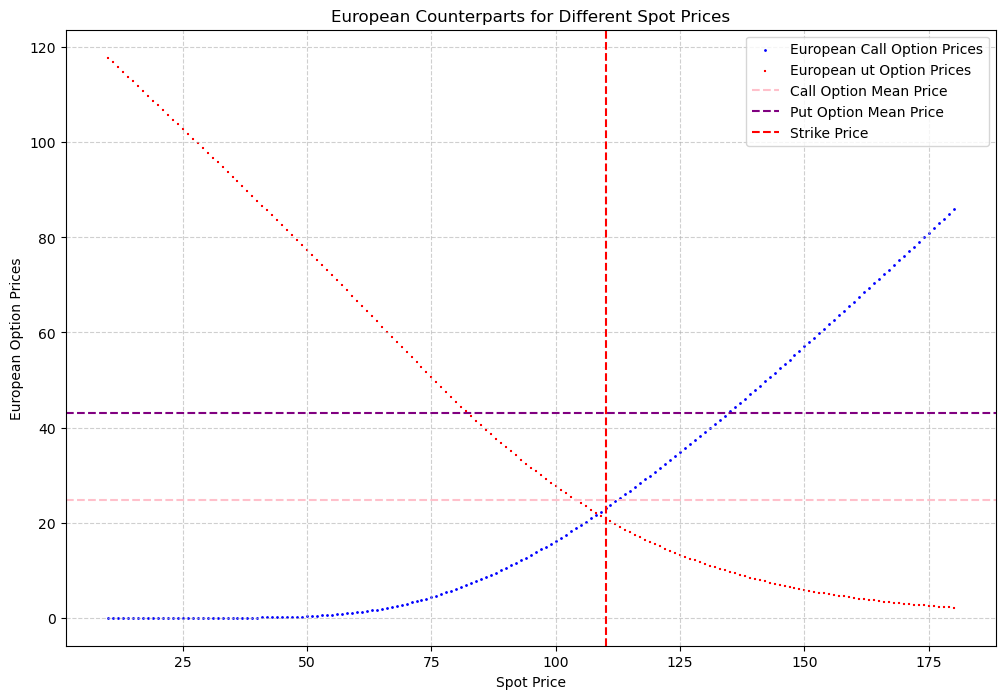

In [16]:
# Plot European option prices over different spot prices (both call and put option)

# Set storage for option prices and variances over various spot prices
european_call_list = np.zeros(len(spot_prices))
european_put_list = np.zeros(len(spot_prices))

# Compute european option prices for each spot price, using the Black-Scholes Formula
for i in range(len(spot_prices)):
    european_call_list[i], european_put_list[i] = BS_price(spot_prices[i], K, T, r, sigma_0)
    
# Plot results, including vertical line for strike price
plt.figure(figsize=(12, 8))  
plt.scatter(spot_prices, european_call_list, color='blue', label='European Call Option Prices', marker='o', s=1)
plt.scatter(spot_prices, european_put_list, color='red', label='European ut Option Prices', marker='+', s=1)
plt.axhline(y=np.mean(european_call_list), color='pink', linestyle='--', label='Call Option Mean Price')
plt.axhline(y=np.mean(european_put_list), color='purple', linestyle='--', label='Put Option Mean Price')
plt.axvline(x=K, color='red', linestyle='--', label='Strike Price')

plt.xlabel("Spot Price")
plt.ylabel("European Option Prices")
plt.title("European Counterparts for Different Spot Prices")
plt.legend()  
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

By comparing the two plots above, it is clear that the Asian option exhibits similarities with a European call option because both depend on the underlying asset's price. However, the Asian option considers the average price over a specific time period rather than the spot price at maturity. This averaging effect tends to reduce the impact of short-term fluctuations in the underlying asset, making the Asian option less sensitive to extreme spot price movements.

The Asian option generally has lower option prices compared to a European call option with the same parameters. This is attributed to the averaging feature in the Asian option's payoff calculation. The averaging tends to smooth out the impact of extreme spot prices, resulting in a less volatile payoff. As a result, the Asian option is less valuable than a European call option in scenarios where extreme spot price movements heavily influence the payoff.


The plot below shows how different times to maturity affects the Asian option prices over the same range of spot prices as before. 


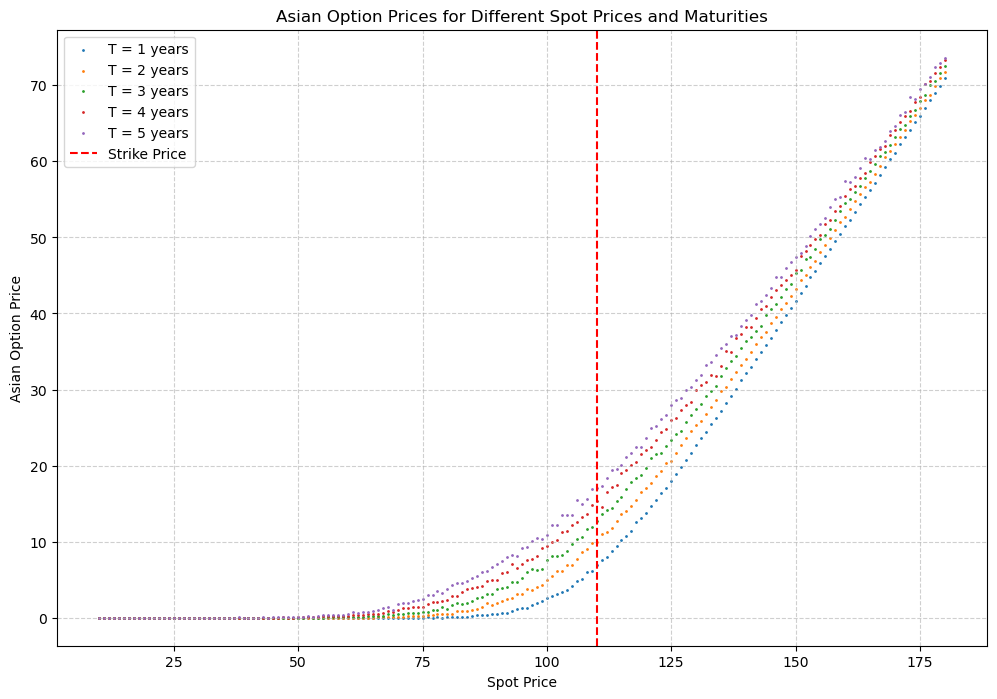

In [17]:
# Plot Asian option prices over different spot prices and for different times to maturity

# Range of time to maturity (T)
maturities = np.arange(1, 6)

# Initialize arrays to store option prices and variances for each maturity
asian_price_list = np.zeros((len(maturities), len(spot_prices)))

# Compute Asian option prices for each spot price and each time to maturity
for i in range(len(maturities)):
    T = maturities[i]
    for j in range(len(spot_prices)):
        asian_price_list[i, j], _ = MC_asian_option_ant(spot_prices[j], K, T, r, sigma_0, Npaths)

# Plot the results for each maturity
plt.figure(figsize=(12, 8))
for i in range(len(maturities)):
    plt.scatter(spot_prices, asian_price_list[i, :], label=f'T = {maturities[i]} years', s=1)

plt.axvline(x=K, color='red', linestyle='--', label='Strike Price')
plt.xlabel("Spot Price")
plt.ylabel("Asian Option Price")
plt.title("Asian Option Prices for Different Spot Prices and Maturities")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

As can be seen from the plot above, the Asian option price increases slightly as the time to maturity (T) increases. This behaviour can be attributed to the averaging mechanism. With a longer time horizon, the averaging process incorporates a larger number of daily closing prices, reducing the impact of short-term fluctuations and contributing to a more stable and predictable payoff. As a result, the option price tends to increase gradually with an increase in the time to maturity.

In summary, the Asian option's averaging feature makes it less sensitive to short-term fluctuations, resulting in lower option prices compared to European call options. The increase in option price with longer time to maturity highlights the stabilising effect of averaging over a larger number of observations.

---

## *Asian Delta Option*

In this final section, the delta for the Asian option (using the antithetic variance reduction technique) will be computed using path recycling over the same range of spot prices as before. The delta reflects the sensitivity of the option's price to changes in the average underlying price over a specified time interval.It is given by the first derivitive of the value of the option (V) with respect to the spot price (S):

$$
\frac{\partial V}{\partial S}
$$
We then evaluate how the time to maturity affects the delta of Asian options. 

In [18]:
# Function to Compute the Asian Delta Option using path recycling for the Antithetic variance reduction method 
def MC_asian_option_ant_delta(S, K, T, r, sigma_0, N):
    
    # Compute option prices for the perturbed spot prices
    S0 = S
    
    # Choose appropriate scalling factor for dS (perturbation in the spot price)
    dS = 0.1 * S0
    
    # Use the SDE_timestepper function to generate positive and negative paths
    _, Sp_up, Sm_up = SDE_timestepper(S0 + dS, K, T, r, sigma_0, Npaths)
    _, Sp_dn, Sm_dn = SDE_timestepper(S0 - dS, K, T, r, sigma_0, Npaths)

    # Compute discounted payoffs for the perturbed spot prices
    fSp_up, fSm_up  = np.exp(-r * T) * np.maximum(np.mean(Sp_up,axis=0) - K, 0),  np.exp(-r * T) * np.maximum(np.mean(Sm_up,axis=0) - K, 0)
    fSp_dn, fSm_dn = np.exp(-r * T) * np.maximum(np.mean(Sp_dn,axis=0) - K, 0),  np.exp(-r * T) * np.maximum(np.mean(Sm_dn,axis=0) - K, 0)

    # Compute delta by finding derivitive w.r.t the spot price
    Z_up = (fSp_up + fSm_up) / 2
    Z_dn = (fSp_dn + fSm_dn) / 2
    dZ_dS = (Z_up - Z_dn) / (2 * dS)
    delta = np.mean(dZ_dS)
    var = np.var(dZ_dS)
    
    return delta, var

The plot below shows how the delta of an Asian option varies with different spot prices.

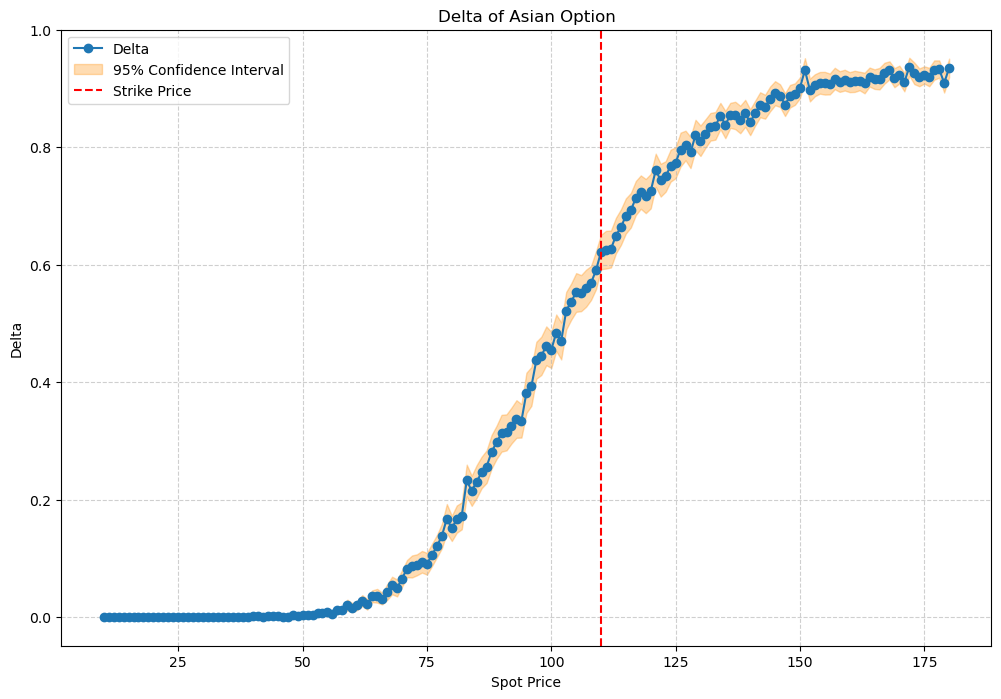

In [19]:
# Plot the Asian Delta Option over a range of spot prices

# Set initial parameters and the range of spot prices to be evaluated
spot_prices = np.arange(10, 181)
K = 110
T = 3
r = 0.05
sigma_0 = 0.2
Npaths = 1000

# Storage for the delta options (prices and variances)
delta_values = np.zeros(len(spot_prices))
delta_var = np.zeros(len(spot_prices))

# Compute the delta for each spot price
for i in range(len(spot_prices)):
    delta_values[i], delta_var[i] = MC_asian_option_ant_delta(spot_prices[i], K, T, r, sigma_0, Npaths)

# Plot the results, including the 95% confidence interval
plt.figure(figsize=(12, 8))
plt.plot(spot_prices, delta_values, marker='o', linestyle='-', label='Delta')
plt.fill_between(spot_prices, delta_values - 1.96*np.sqrt(delta_var/Npaths), delta_values + 1.96*np.sqrt(delta_var/Npaths), alpha=0.3, color = 'darkorange', label='95% Confidence Interval')
plt.axvline(x=K, color='red', linestyle='--', label='Strike Price')
plt.xlabel("Spot Price")
plt.ylabel("Delta")
plt.title("Delta of Asian Option")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Thus, this plot shows that as the spot price increases, delta rises, signifying the option's heightened responsiveness to market movements. Notably, options near the strike price exhibit a delta around 0.5, indicating equal likelihood of in-the-money or out-of-the-money outcomes with small spot price shifts. For in-the-money options, delta approaches 1, reflecting a close correlation between the option's price and spot price. Conversely, out-of-the-money options have lower delta, reflecting their reduced intrinsic value and lower likelihood of profitable outcomes.

The plot below shows how different times to maturity affects the deltas of an Asian option over the same range of spot prices as before. 

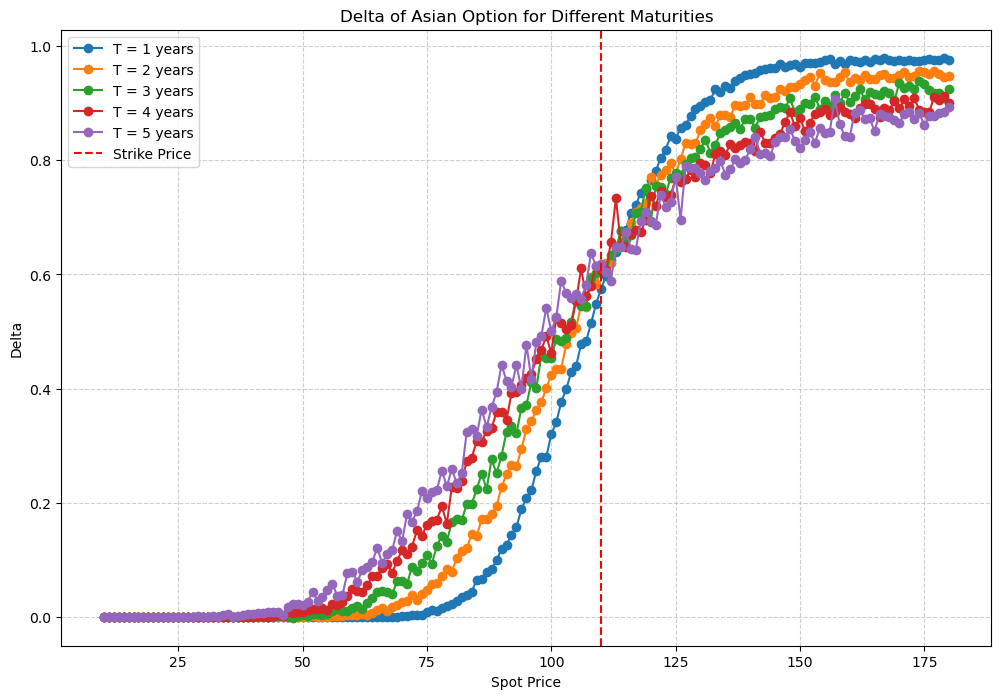

In [20]:
# Range of time to maturity (T)
maturities = np.arange(1, 6)
num_maturities = len(maturities)

# Storage for delta values and variances for each maturity
delta_values = np.zeros((num_maturities, len(spot_prices)))
delta_var = np.zeros((num_maturities, len(spot_prices)))

# Compute the delta for each spot price and each maturity
for i in range(num_maturities):
    T = maturities[i]
    for j in range(len(spot_prices)):
        delta_values[i, j], delta_var[i, j] = MC_asian_option_ant_delta(spot_prices[j], K, T, r, sigma_0, Npaths)

# Plot the results for each maturity
plt.figure(figsize=(12, 8))
for i in range(num_maturities):
    plt.plot(spot_prices, delta_values[i, :], marker='o', linestyle='-', label=f'T = {maturities[i]} years')
    
plt.axvline(x=K, color='red', linestyle='--', label='Strike Price')
plt.xlabel("Spot Price")
plt.ylabel("Delta")
plt.title("Delta of Asian Option for Different Maturities")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The plot above shows that the delta is higher before the strike price with greater time to maturity. This is because a longer time horizon allows for more opportunities for the spot price to move toward or cross the strike price, impacting the option's profitability. For a call option, a higher delta indicates that the option is more sensitive to upward movements in the spot price. With more time until expiration, there's a greater chance that the spot price might reach or exceed the strike, making the call option more likely to be profitable.

However, when the spot price is greater than the strike price (in-the-money), and time to maturity is higher, the delta is lower. This is because the option is already in a favourable position, and the impact of additional time on its sensitivity diminishes. For a call option, a lower delta indicates reduced sensitivity to further upward movements in the spot price. The option is already in-the-money, and the incremental impact of time on its potential profitability diminishes.

Understanding the relationship between delta, time to maturity, and spot price is crucial for traders in managing risk and making strategic decisions. In scenarios where the spot price is below the strike, a longer time horizon increases the potential for favorable movements


Delta is a crucial metric for options traders and investors, serving as a key risk measure by quantifying an option's sensitivity to changes in the underlying asset's price. In the context of Asian options, delta provides valuable insights into how the option's value reacts to fluctuations in the average underlying price over time. From a financial perspective, delta plays a multifaceted role. It is instrumental in hedging strategies, enabling traders to offset risk by taking opposite positions in the underlying asset and maintaining a delta-neutral portfolio. Moreover, delta facilitates risk assessment, with a higher delta signalling increased sensitivity and potential risk exposure for a portfolio in response to underlying asset price changes. A comprehensive understanding of delta is essential for informed decision-making in options trading, aiding investors to effectively manage risk and optimise portfolio performance in dynamic market conditions. 

---

## *Conclusion*

In the exploration of pricing Fixed Strike Asian Call Options using Monte Carlo simulations, the focus was on comparing various methods, specifically the naive Monte Carlo method, antithetic variance reduction, and control variates. The objective was to strike a balance between accuracy and computational efficiency.

The antithetic variance reduction method emerged as the most efficient in reducing variance, leading to narrower confidence intervals and more accurate results. In contrast, control variates were less effective in reducing variance due to the path dependency of Asian options and challenges in finding suitable linear relationships for control variates.

As we delved into how Asian option prices vary with different stock prices, it became evident that, similar to European call options, Asian option prices increase with higher spot prices. The averaging mechanism in Asian options, which considers the average price over a specific time period, results in generally lower option prices compared to European call options. The impact of short-term price fluctuations is mitigated, making Asian options less sensitive to market volatility.
Analysing the delta of Asian options, we found that delta is a crucial risk measure, reflecting the sensitivity of the option's price to changes in the average underlying price over time. Delta tends to increase with spot prices, indicating a positive correlation between option price and spot price. Additionally, the delta increases with time to maturity, highlighting the stabilising effect of averaging over a larger number of observations. Understanding delta is pivotal for options traders and investors. It plays a key role in hedging strategies, risk assessment, and constructing option strategies based on market outlook and risk tolerance. The trade-off between accuracy and computational cost must be carefully evaluated when choosing variance reduction techniques, with antithetic variance reduction proving effective in high-variance situations.

In conclusion, the decision to use variance reduction techniques, especially antithetic variance reduction, depends on assessing the trade-offs between computational cost and desired variance reduction. Thorough testing and validation across various scenarios are essential in making informed decisions. The Asian option's unique features, such as path dependency and averaging, contribute to its distinct pricing dynamics, and understanding these nuances is crucial for effective risk management and strategic decision-making in financial markets.

